In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i[:4])
target['team_a'] = target.index.map(lambda i: i[5:9])
target['team_b'] = target.index.map(lambda i: i[10:14])
target['in_target'] = True
target.sample()

,Season,team_a,team_b,in_target
ID,,,,
2017_1266_1278,2017,1266,1278,True


In [3]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
ncaa_games['is_ncaa_game'] = True
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 10)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff,is_ncaa_game
1148,2003,136,1323,70,1454,69,N,0,1,True


In [4]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
regular_games['is_ncaa_game'] = False
print(regular_games.shape)
regular_games.sample()

(150684, 10)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff,is_ncaa_game
61821,2000,52,1163,84,1193,60,H,0,24,False


In [5]:
rankings_teams = pd.read_csv('data/MasseyOrdinals.csv')
rankings_teams = rankings_teams.astype({
    'TeamID' : str,
    'Season' : str
})
print(rankings_teams.shape)
rankings_teams.sample()

(3200201, 5)


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
2216256,2014,107,MAS,1221,150


In [83]:
data = pd.concat([ncaa_games, regular_games])
# data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 5
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_season = regular_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['Season', 'team_{}'.format(team)], 
                    right_index=True,
                    how='left')
    
    
    # SEASON WINS AGAINST THE OPPONENT
    season_wins_against_opponent = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)}).fillna(0)
    for l in range(1, lags+1):
        season_wins_against_opponent['season_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
            season_wins_against_opponent['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # AVERAGE DIFF TO OPPONENT IN THE SEASON
    average_win_diff = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).mean()[['diff']]\
        .rename(columns={'diff': 'average_win_diff_{}'.format(team)})
    for l in range(1, lags+1):
        average_win_diff[
            'average_win_diff_{}_lag-{}'.format(team, l)] = average_win_diff[
            'average_win_diff_{}'.format(team)
        ].shift(l).fillna(0)
    average_win_diff.drop('average_win_diff_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, average_win_diff,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['Season', 'team_{}'.format(team)], 
                    right_index=True,
                    how='left').fillna(0)

    
    # AVERAGE RANKING OF TEAMS IN PAST SEASONS
    average_rank_teams = rankings_teams\
        .groupby([ 'TeamID','Season',]).mean()[['OrdinalRank']]\
        .rename(columns={'OrdinalRank':'average_rank_team_{}'.format(team)})
    for l in range(1, lags+1):
        average_rank_teams[
            'average_rank_team_{}_lag-{}'.format(team, l)] = average_rank_teams[
            'average_rank_team_{}'.format(team)
        ].shift(l).fillna(0)
    average_rank_teams.drop('average_rank_team_{}'.format(team), inplace = True, axis = 1)
    data = pd.merge(data, average_rank_teams,
                    left_on=['team_{}'.format(team), 'Season'],
                    right_index = True,
                    how='left').fillna(0)
    
data = data.dropna()
print(data.shape)
data.head(5)

(161913, 55)


,Season,a_win,in_target,team_a,team_b,won_in_season_a_lag-1,won_in_season_a_lag-2,won_in_season_a_lag-3,won_in_season_a_lag-4,won_in_season_a_lag-5,...,won_in_ncaa_b_lag-1,won_in_ncaa_b_lag-2,won_in_ncaa_b_lag-3,won_in_ncaa_b_lag-4,won_in_ncaa_b_lag-5,average_rank_team_b_lag-1,average_rank_team_b_lag-2,average_rank_team_b_lag-3,average_rank_team_b_lag-4,average_rank_team_b_lag-5
0,1985,True,False,1116,1234,17.0,11.0,18.0,10.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,15.0,11.0,21.0,17.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,17.0,20.0,13.0,5.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,23.0,13.0,10.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,12.0,13.0,8.0,17.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Problem with the variables created: When shifting (l) rows down, teams get the avg ranking from the previous team if it's their first years. TODO 

In [84]:
data.describe()

,won_in_season_a_lag-1,won_in_season_a_lag-2,won_in_season_a_lag-3,won_in_season_a_lag-4,won_in_season_a_lag-5,season_wins_against_opponent_a_lag-1,season_wins_against_opponent_a_lag-2,season_wins_against_opponent_a_lag-3,season_wins_against_opponent_a_lag-4,season_wins_against_opponent_a_lag-5,...,won_in_ncaa_b_lag-1,won_in_ncaa_b_lag-2,won_in_ncaa_b_lag-3,won_in_ncaa_b_lag-4,won_in_ncaa_b_lag-5,average_rank_team_b_lag-1,average_rank_team_b_lag-2,average_rank_team_b_lag-3,average_rank_team_b_lag-4,average_rank_team_b_lag-5
count,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,...,161913.000000,161913.000000,161913.00000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000,161913.000000
mean,14.226949,14.149006,14.165540,14.248541,14.129458,8.728329,8.788275,8.791969,8.858764,8.869072,...,0.268212,0.269515,0.27172,0.271541,0.271776,83.952434,84.639604,85.329983,85.355490,85.512232
std,6.143611,6.110552,6.075906,6.119469,6.077055,11.814573,11.872843,11.860025,11.932756,11.949854,...,0.805577,0.806946,0.81551,0.819954,0.820592,105.103301,105.152106,105.522510,105.547708,105.834062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,14.000000,14.000000,14.000000,14.000000,3.000000,3.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,20.805936,21.911765,22.406109,21.951025,21.656805
75%,19.000000,18.000000,18.000000,19.000000,18.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,162.436585,164.000000,165.679186,166.501166,168.165829
max,34.000000,34.000000,34.000000,34.000000,34.000000,129.000000,120.000000,129.000000,129.000000,129.000000,...,6.000000,6.000000,6.00000,6.000000,6.000000,350.113356,350.113356,350.113356,350.113356,350.113356


In [88]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=5, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    logreg = linear_model.LogisticRegression(C=1e5)
    logreg.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = logreg.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))


0.28986980816
0.290793719253
0.285816128616
0.288039031406
0.293710348578
Metric Mean: 0.29 (0.00)


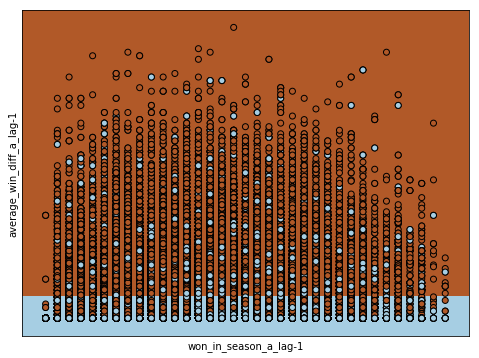

In [89]:
# Plot the decision boundary. 
X_db = X.iloc[:, [0, 10]]

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_db.values, y.values.reshape(-1))

h = .02
x_min, x_max = X_db.iloc[:, 0].min() - 2, X_db.iloc[:, 0].max() + 2
y_min, y_max = X_db.iloc[:, 1].min() - 5, X_db.iloc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_db.iloc[:, 0], X_db.iloc[:, 1], c=(y.values * 1).ravel(), edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(X_db.columns[0])
plt.ylabel(X_db.columns[1])

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [90]:
pd.Series(X.columns)

0                    won_in_season_a_lag-1
1                    won_in_season_a_lag-2
2                    won_in_season_a_lag-3
3                    won_in_season_a_lag-4
4                    won_in_season_a_lag-5
5     season_wins_against_opponent_a_lag-1
6     season_wins_against_opponent_a_lag-2
7     season_wins_against_opponent_a_lag-3
8     season_wins_against_opponent_a_lag-4
9     season_wins_against_opponent_a_lag-5
10                average_win_diff_a_lag-1
11                average_win_diff_a_lag-2
12                average_win_diff_a_lag-3
13                average_win_diff_a_lag-4
14                average_win_diff_a_lag-5
15                     won_in_ncaa_a_lag-1
16                     won_in_ncaa_a_lag-2
17                     won_in_ncaa_a_lag-3
18                     won_in_ncaa_a_lag-4
19                     won_in_ncaa_a_lag-5
20               average_rank_team_a_lag-1
21               average_rank_team_a_lag-2
22               average_rank_team_a_lag-3
23         

In [91]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X.values, y.values.reshape(-1))
preds = logreg.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.590137
2014_1107_1112,0.283919
2014_1107_1113,0.624986
2014_1107_1124,0.301767
2014_1107_1140,0.505566


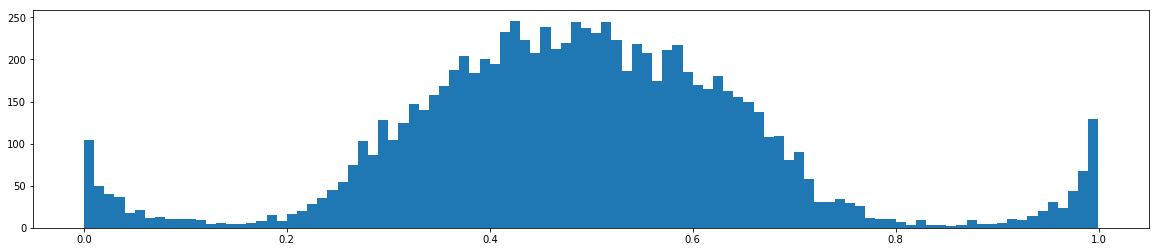

In [92]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [93]:
sub.to_csv('submissions/logreg_baseline_1.csv')

In [94]:
lgbm = pd.read_csv('submissions/lgbm_baseline_1.csv')
logreg = pd.read_csv('submissions/logreg_baseline_1.csv')

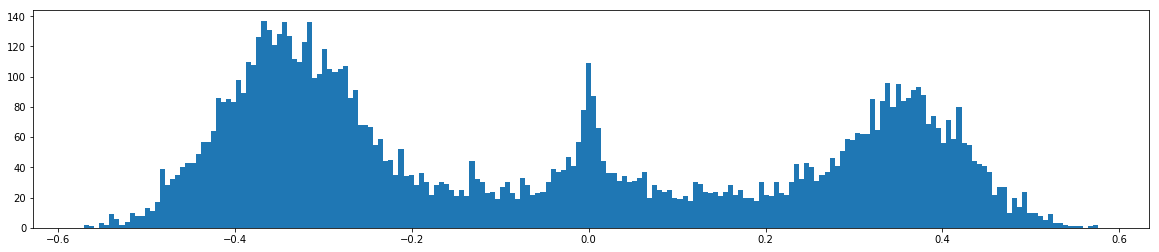

In [95]:
plt.figure(figsize=(20,4))
plt.hist(lgbm['Pred'] - three['Pred'], bins=200)
plt.show()